# Medical Cost Prediction

Las aseguradoras de salud desempeñan un papel fundamental a nivel mundial, proporcionando una red de seguridad financiera esencial para los individuos ante enfermedades y emergencias médicas. Estas compañías operan bajo un modelo de negocio intrínsecamente ligado al riesgo, pues el momento y la severidad de las enfermedades de sus asegurados son inherentemente impredecibles. Para mantener su viabilidad y ofrecer un servicio de calidad, las aseguradoras deben no solo cubrir sus costos sino también generar ganancias.

A pesar de la incertidumbre que rodea la frecuencia y el tipo de reclamaciones, ciertas condiciones de salud, hábitos de vida y características demográficas ofrecen indicativos valiosos que pueden ayudar a prever si un individuo podría representar un gasto mayor. En este contexto, los modelos predictivos emergen como herramientas cruciales, permitiendo a las aseguradoras estimar de manera aproximada los costos futuros asociados a cada asegurado. Estos modelos utilizan datos históricos y tendencias para predecir gastos, facilitando así una gestión más eficiente del riesgo.

El objetivo de este proyecto es proporcionar a la compañía de seguros un sistema que oriente a sus asesores, permitiéndoles tomar decisiones informadas basadas en las recomendaciones sobre los costos previstos por un modelo previamente entrenado. Para ello, se construirá un modelo de regresión utilizando un dataset de 4,000 registros de pacientes. Cada registro incluye diversos datos sobre condiciones de salud y hábitos de vida, los cuales ya están siendo utilizados para calcular las tarifas mensuales de los servicios. Este modelo no solo busca mejorar la precisión en la predicción de los costos, sino también optimizar las estrategias de precios y políticas de cobertura para mejorar la rentabilidad y eficacia del servicio ofrecido.

<img src="medical_cost_illustration.gif" width="400px">


### Loading data
En primer lugar importamos las librerias que utilizaremos para el tratamiento de los datos, y los datos como tal.

Además se configura la manera en que se mostrarán los datos en el notebook.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [4]:
%matplotlib inline

sns.set(style = "whitegrid", context = "notebook")
sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
plt.rcParams["figure.figsize"] = (15, 10)

import warnings
warnings.filterwarnings("ignore")


In [5]:
original_df = pd.read_csv('../data/insurance.csv')
df_raw = original_df.copy(deep=True)

In [6]:
df_raw

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Entendiendo los datos (EDA)
Para no dejar nada en el camino es fundamental comprender nuestros datos, a continuación llevaremos a cabo un **Análisis Exploratorio de datos**, comprendiendo cómo se comportan las observaciones y qué información nos pueden entregar.

### Tamaño y dimensionalidad

In [7]:
df_eda = df_raw.copy(deep=True)

print(f"El dataset original tiene {df_eda.shape[0]} observaciones y {df_eda.shape[1]} variables.")

El dataset original tiene 1338 observaciones y 7 variables.


### Categorización de las variables
La fuente de los datos nos brinda la siguiente información : 
| Campo    | Descripción                                                                                                         |
|----------|---------------------------------------------------------------------------------------------------------------------|
| age      | Edad del beneficiario principal                                                                               |
| sex      | Género del contratante del seguro                                                |
| bmi      | Índice de masa corporal                                                                                             |
| children | Número de hijos cubiertos por el seguro de salud / Número de dependientes                                             |
| smoker   | Fumador                                                                                           |
| region   | Área residencial del beneficiario en los EE. UU.  |
| charges  | Costos médicos individuales facturados por el seguro de salud                                                       |




A continuación realizaremos la validación de que los datos informados por la fuente está correcta, y verificamos los tipos de datos, y el comportamiento, de cada variable.

In [8]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [9]:
df_eda.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [10]:
df_eda.select_dtypes(include = ["object"]).describe()

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Notemos que:
* Las variables numéricas continua son :   _age_, _bmi_, y _charges_.
* Las variables numéricas discretas son :   _children_.
* Las variables categóricas nominales son :   _sex_, _smoker_ y _region_.
* Tanto las variables categóricas como las numéricas no parecen presentar valores faltantes de manera implícita. ya que sus
    datos parecen, tanto en mínimos como en los máximos, estar dentro de los rangos esperados. por lo que podemos concluir que no hay datos faltantes en el dataset.
* La variable _charges_ es la variable objetivo.

### Análisis de variables numéricas

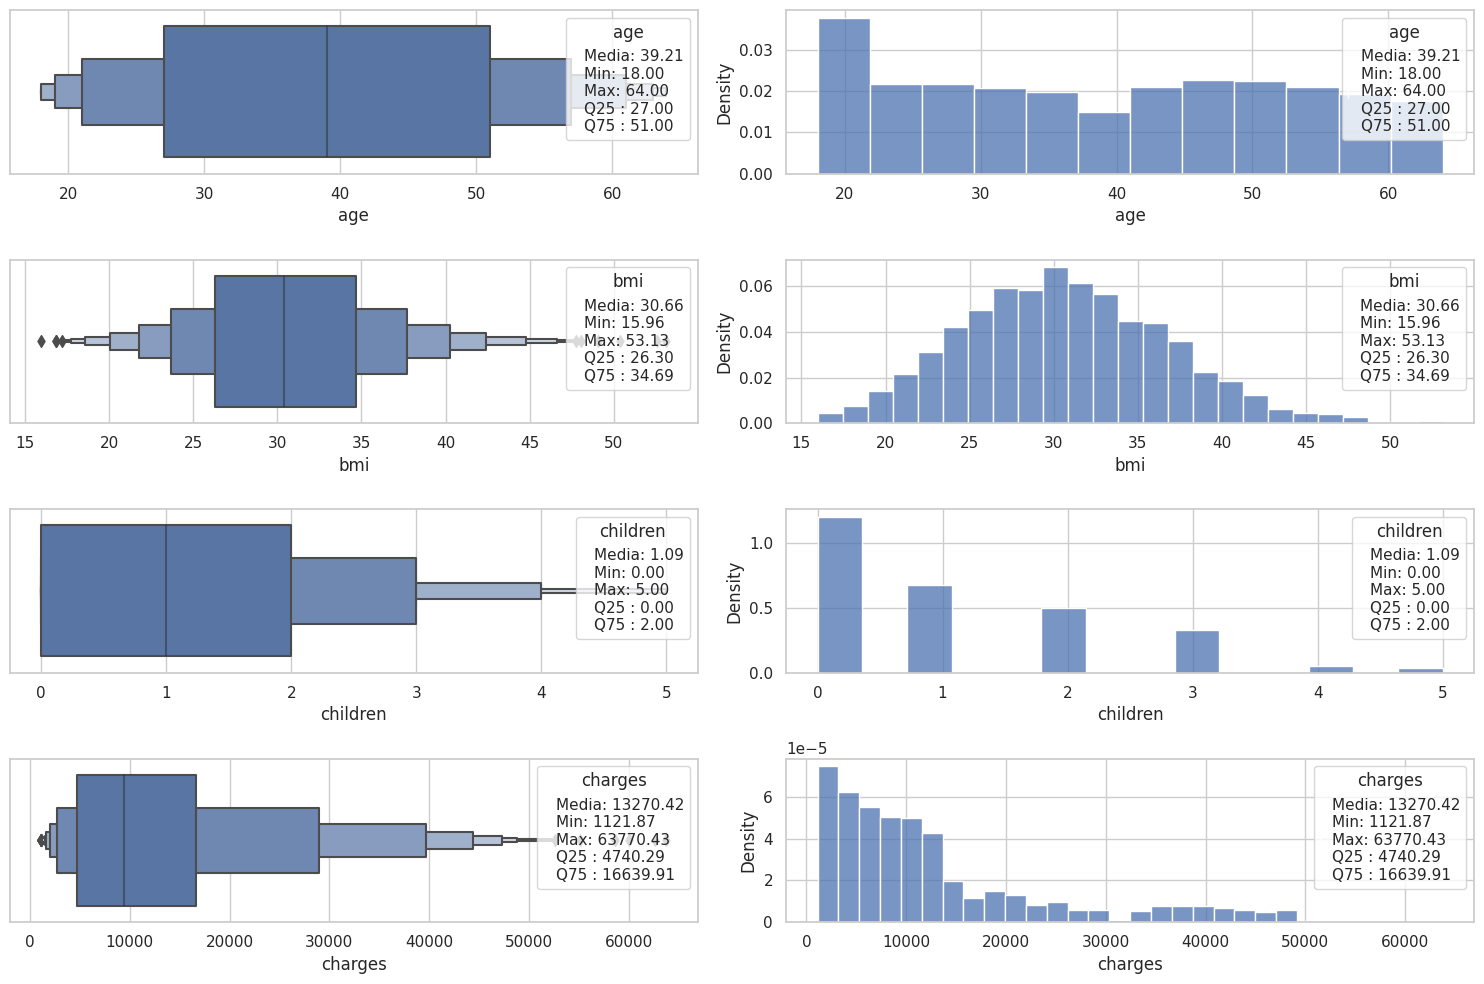

In [33]:
numerical_variables = df_eda.select_dtypes(include = [np.number]).columns

# Hagamos un boxenplot de cada variable, para observar sus rangos y la posible presencia de outliers

for idx, col in enumerate(numerical_variables):
    plt.subplot(4, 2, idx *2 + 1)
    sns.boxenplot(x = df_eda[col])

    # Calcula los valores mínimos, máximos y medios
    min_val = df_eda[col].min()
    max_val = df_eda[col].max()
    mean_val = df_eda[col].mean()
    q25 = df_eda[col].quantile(0.25)
    q75 = df_eda[col].quantile(0.75)
    
    # Agrega la leyenda al gráfico y quita el icono de la leyenda
    plt.legend([f'Media: {mean_val:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}\nQ25 : {q25:.2f}\nQ75 : {q75:.2f}'], loc='upper right', title=col, handlelength=0)


for idx, col in enumerate(numerical_variables):
    plt.subplot(4, 2, idx * 2 + 2)

    # Hagamos que este histograma sea porcentual
    sns.histplot(x = df_eda[col], stat = 'density')

    # Calcula los valores mínimos, máximos y medios
    min_val = df_eda[col].min()
    max_val = df_eda[col].max()
    mean_val = df_eda[col].mean()
    q25 = df_eda[col].quantile(0.25)
    q75 = df_eda[col].quantile(0.75)
    
    # Agrega la leyenda al gráfico y quita el icono de la leyenda
    plt.legend([f'Media: {mean_val:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}\nQ25 : {q25:.2f}\nQ75 : {q75:.2f}'], loc='upper right', title=col, handlelength=0)


plt.tight_layout()  # Ajusta automáticamente los subplots para que se ajusten al área de la figura
plt.show()  # Muestra los gráficos

**Observamos que** 
* Las edades en nuestra muestra varian entre los 18 y 64 años.
* La edad se distribuye aproximadamente de manera uniforme en la muestra, con una ligera concentración en los rangos de 20 a 30 años.
* El Indice de Masa Corporal (BMI) se distribuye aproximadamente de manera normal, sin embargo, la media está por encima de 30, lo cual indica que al menos el 50% de los individuos en la muestra tienen sobrepeso.
* El 75% de los individuos en la muestra tienen como máximo 2 hijos.
* Los cargos por seguros varían ampliamente, con una media significativamente alta en comparación con el Q25, lo que podría indicar que hay un pequeño número de casos con costos extremadamente altos

### Análisis de variables categóricas

In [22]:
categorical_variables = df_eda.select_dtypes(include='object').columns

In [24]:

print('Categorical variables\n')
print(df_eda[categorical_variables].describe())

Categorical variables

         sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364


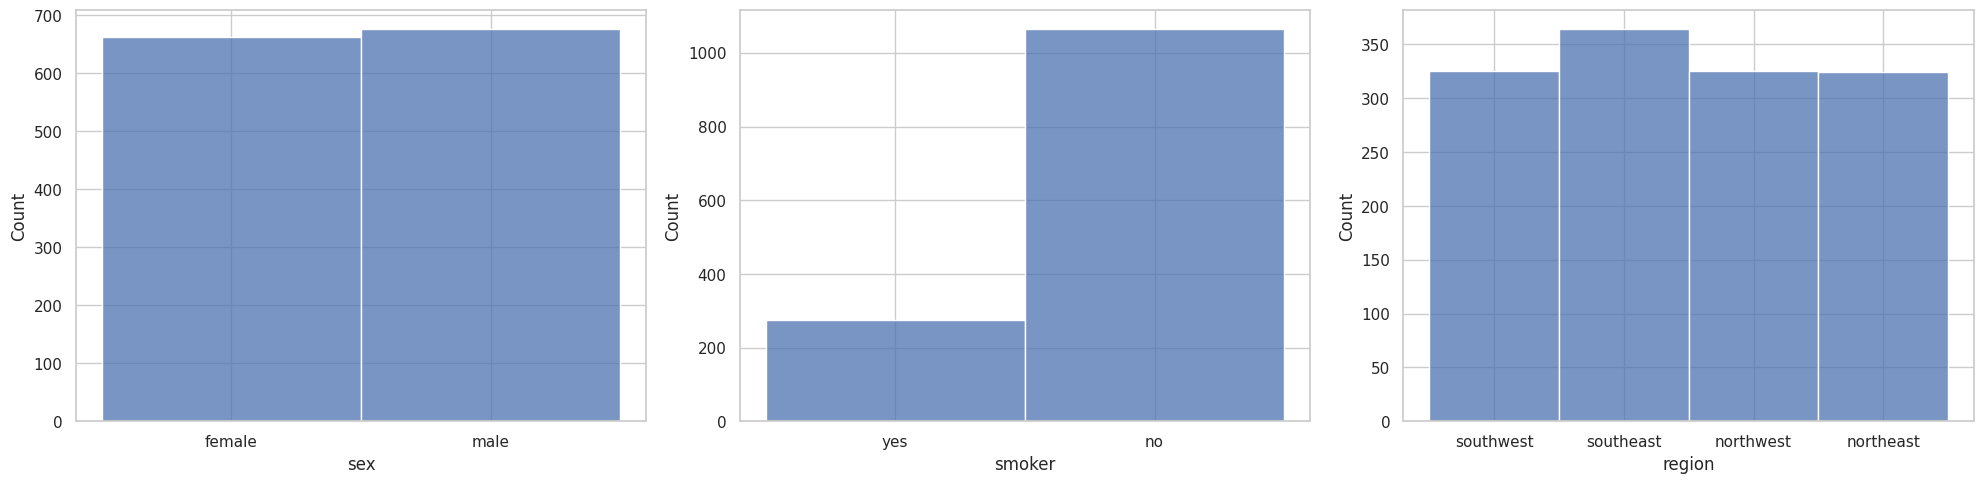

In [38]:
## A continuacion hagamos un countplot para cada una de las varibales categoricas
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for ax, var in zip(axes.flatten(), categorical_variables):
    sns.histplot(x=var, data=df_eda, ax=ax)



plt.tight_layout()

**Observamos que** 
* La muestra está equilibrada en términos de género.
* La mayoría de los individuos en la muestra no son fumadores, por lo cual sería interesante ver la influencia de este factor en los costos.
* La distribución por regiones muestra que hay una distribución relativamente equilibrada entre las cuatro regiones.

### Análisis de la influencia de la variable _smoker_ en los costos.

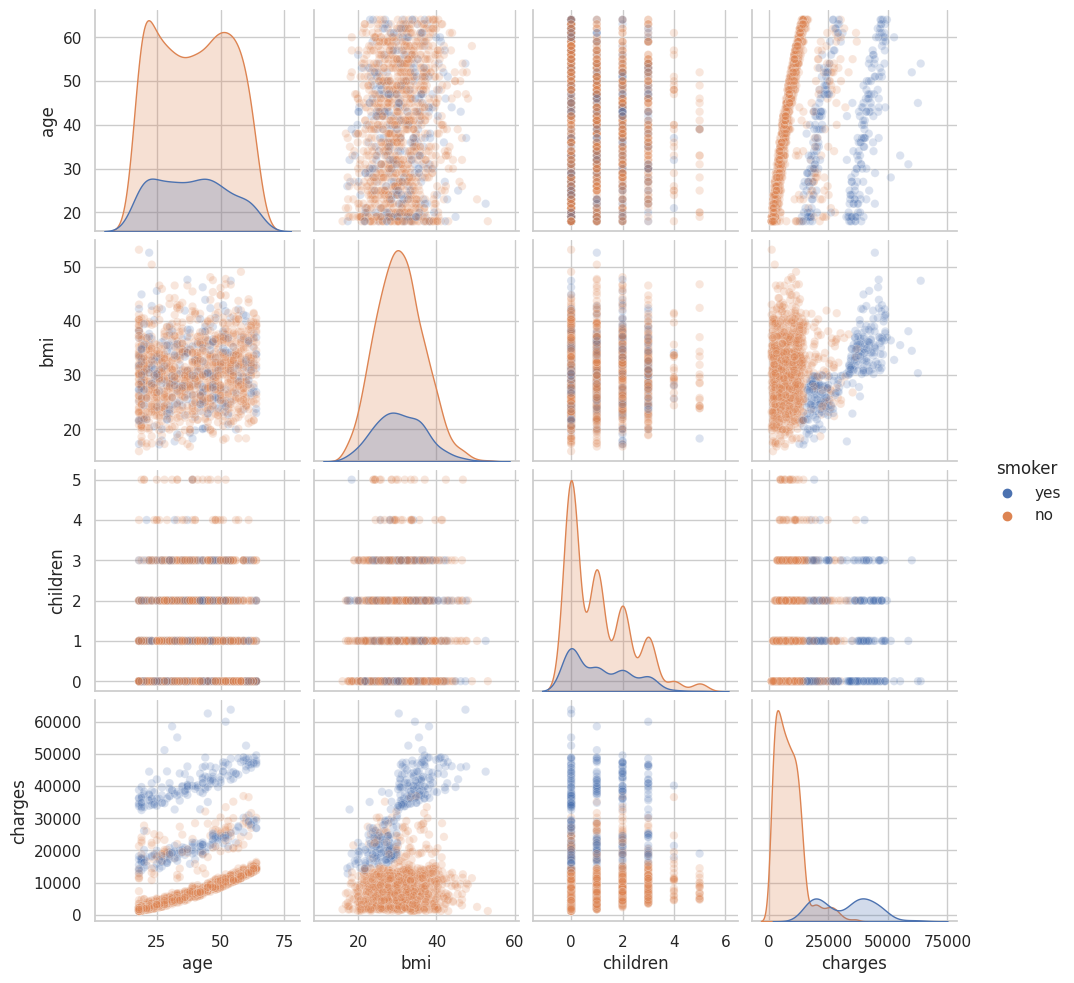

In [55]:
sns.pairplot(df_eda, hue='smoker', plot_kws={'alpha':1/5})

De este diagrama de pares podemos observar que:
* La relación entre edad y costo es positiva, lo que indica que a medida que la edad aumenta, los costos tienden a ser más altos.
* Además, los fumadores tienden a tener costos más altos que los no fumadores, independientemente de la edad.